<a href="https://colab.research.google.com/github/YasinEnigma/Scripts/blob/master/osteoarthritis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/t9ndx37v5h-1.zip

--2023-05-12 06:49:05--  https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/t9ndx37v5h-1.zip
Resolving prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)... 52.218.29.40, 52.218.109.128, 52.92.0.194, ...
Connecting to prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)|52.218.29.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121644222 (116M) [application/octet-stream]
Saving to: ‘t9ndx37v5h-1.zip’

t9ndx37v5h-1.zip    100%[===================>] 116.01M  27.5MB/s    in 4.9s    

2023-05-12 06:49:10 (23.5 MB/s) - ‘t9ndx37v5h-1.zip’ saved [121644222/121644222]



In [2]:
!unzip t9ndx37v5h-1.zip

Archive:  t9ndx37v5h-1.zip
   creating: Knee X-ray Images/
  inflating: Knee X-ray Images/MedicalExpert-I.rar  
  inflating: Knee X-ray Images/MedicalExpert-II.rar  


In [3]:
!unrar x '/content/Knee X-ray Images/MedicalExpert-I.rar'


UNRAR 5.61 beta 1 freeware      Copyright (c) 1993-2018 Alexander Roshal


Extracting from /content/Knee X-ray Images/MedicalExpert-I.rar

Creating    MedicalExpert-I                                           OK
Creating    MedicalExpert-I/0Normal                                   OK
Extracting  MedicalExpert-I/0Normal/NormalG0 (1).png                       0%  OK 
Extracting  MedicalExpert-I/0Normal/NormalG0 (10).png                      0%  OK 
Extracting  MedicalExpert-I/0Normal/NormalG0 (100).png                     0%  OK 
Extracting  MedicalExpert-I/0Normal/NormalG0 (101).png                     0%  OK 
Extracting  MedicalExpert-I/0Normal/NormalG0 (102).png                     0%  OK 
Extracting  MedicalExpert-I/0Normal/NormalG0 (103).png                     0%  OK 
Extracting  MedicalExpert-I/0Normal/NormalG0 (104).png                     0%  OK 
Extracting  MedicalExpert-I/0Normal/NormalG0 (105).png                

In [4]:
import cv2,os
data_path='/content/MedicalExpert-I/'
categories=os.listdir(data_path)
labels=[i for i in range(len(categories))]

label_dict=dict(zip(categories,labels)) #empty dictionary
print(label_dict)
print(categories)
print(labels)

{'0Normal': 0, '1Doubtful': 1, '3Moderate': 2, '4Severe': 3, '2Mild': 4}
['0Normal', '1Doubtful', '3Moderate', '4Severe', '2Mild']
[0, 1, 2, 3, 4]


In [5]:
img_size=256
data=[]
label=[]

for category in categories:
    folder_path=os.path.join(data_path,category)
    img_names=os.listdir(folder_path)
        
    for img_name in img_names:
        img_path=os.path.join(folder_path,img_name)
        img=cv2.imread(img_path)
        try:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  
            resized=cv2.resize(gray,(img_size,img_size))
            #resizing the image  into 256 x 256, since we need a fixed common size for all the images in the dataset
            data.append(resized)
            label.append(label_dict[category])
            #appending the image and the label(categorized) into the list (dataset)
        except Exception as e:
            print('Exception:',e)
            #if any exception rasied, the exception will be printed here. And pass to the next image

In [6]:
import numpy as np
data=np.array(data)/255.0
data=np.reshape(data,(data.shape[0],img_size,img_size,1))
label=np.array(label)
from keras.utils import np_utils
new_label=np_utils.to_categorical(label)

In [7]:
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
from keras.layers import Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint

model=Sequential()

model.add(Conv2D(128,(3,3),input_shape=data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The first CNN layer followed by Relu and MaxPooling layers

model.add(Conv2D(64,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The second convolution layer followed by Relu and MaxPooling layers

model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#The thrid convolution layer followed by Relu and MaxPooling layers

model.add(Flatten())
#Flatten layer to stack the output convolutions from 3rd convolution layer
model.add(Dropout(0.2))

model.add(Dense(128,activation='relu'))
#Dense layer of 128 neurons

model.add(Dropout(0.1))
model.add(Dense(64,activation='relu'))
#Dense layer of 64 neurons

model.add(Dense(5,activation='softmax'))
#The Final layer with two outputs for two categories

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [8]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(data,new_label,test_size=0.1)

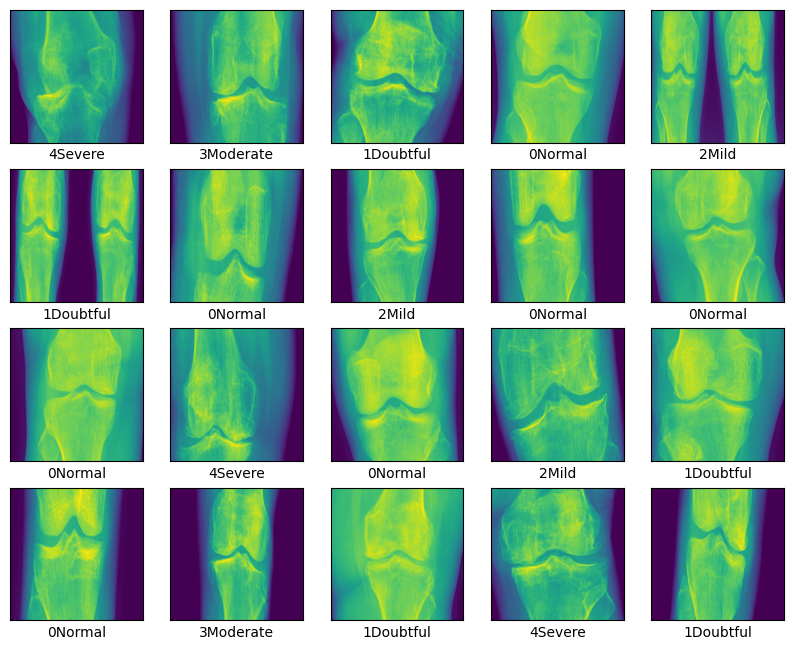

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(20):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(np.squeeze(x_test[i]))
    plt.xlabel(categories[np.argmax(y_test[i])])
plt.show()

In [10]:
history=model.fit(x_train,y_train,epochs=100,validation_split=0.2)

Epoch 1/100
38/38 [==============================] - 22s 166ms/step - loss: 1.5671 - accuracy: 0.2870 - val_loss: 1.5227 - val_accuracy: 0.3434
Epoch 2/100
38/38 [==============================] - 5s 121ms/step - loss: 1.5526 - accuracy: 0.3098 - val_loss: 1.5079 - val_accuracy: 0.3367
Epoch 3/100
38/38 [==============================] - 5s 123ms/step - loss: 1.5152 - accuracy: 0.3157 - val_loss: 1.5139 - val_accuracy: 0.2761
Epoch 4/100
38/38 [==============================] - 5s 121ms/step - loss: 1.4937 - accuracy: 0.3350 - val_loss: 1.4737 - val_accuracy: 0.3266
Epoch 5/100
38/38 [==============================] - 5s 121ms/step - loss: 1.4683 - accuracy: 0.3771 - val_loss: 1.4632 - val_accuracy: 0.3367
Epoch 6/100
38/38 [==============================] - 5s 122ms/step - loss: 1.4262 - accuracy: 0.3754 - val_loss: 1.4302 - val_accuracy: 0.3737
Epoch 7/100
38/38 [==============================] - 5s 121ms/step - loss: 1.3845 - accuracy: 0.3990 - val_loss: 1.4260 - val_accuracy: 0.336

In [11]:
model.save('model.h5')

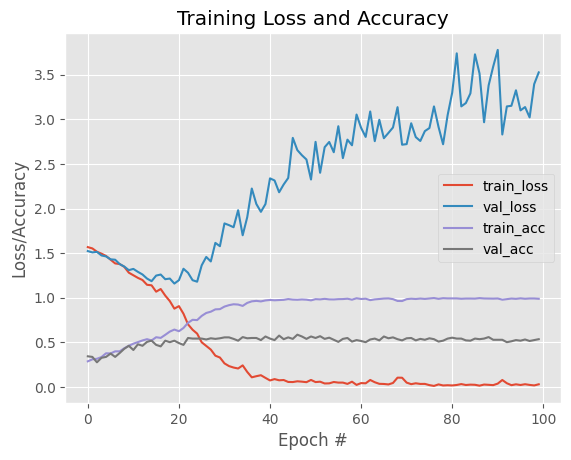

In [12]:
from matplotlib import pyplot as plt
# plot the training loss and accuracy
N = 100 #number of epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.savefig("CNN_Model")

In [13]:
vaL_loss, val_accuracy= model.evaluate(x_test, y_test, verbose=0)
print("test loss:", vaL_loss,'%')
print("test accuracy:", val_accuracy,"%")

test loss: 3.849374532699585 %
test accuracy: 0.5151515007019043 %


1/1 [==============================] - 0s 285ms/step
A.I predicts: 1Doubtful
Correct prediction for label 1 is 1Doubtful


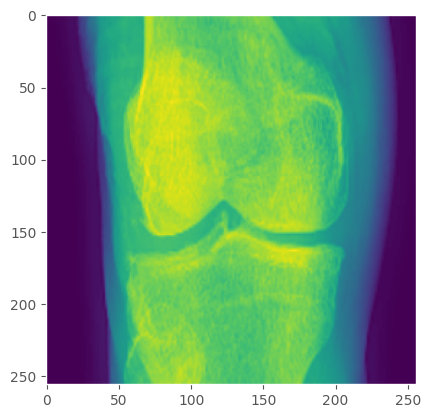

In [14]:
X = 32
img_size = 256
img_single = x_test[X]
img_single = cv2.resize(img_single, (img_size, img_size))
img_single = (np.expand_dims(img_single, 0))
img_single = img_single.reshape(img_single.shape[0],256,256,1)

predictions_single = model.predict(img_single)
print('A.I predicts:',categories[np.argmax(predictions_single)])
print("Correct prediction for label",np.argmax(y_test[X]),'is',categories[np.argmax(y_test[X])])
plt.imshow(np.squeeze(img_single))
plt.grid(False)
plt.show()

6/6 [==============================] - 0s 29ms/step


<Figure size 640x480 with 0 Axes>

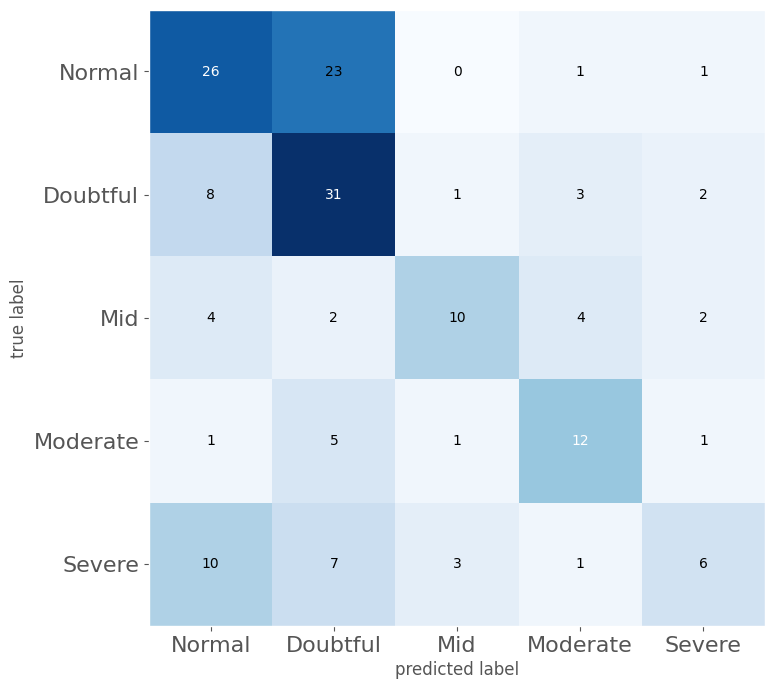

In [15]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

test_labels = np.argmax(y_test, axis=1)
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=-1)

cm  = confusion_matrix(test_labels, predictions)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(5), ['Normal','Doubtful','Mid','Moderate','Severe'], fontsize=16)
plt.yticks(range(5), ['Normal','Doubtful','Mid','Moderate','Severe'], fontsize=16)
plt.show()